Lets begin by importing the various packages we will be using for this notebook

In [2]:
import os
os.chdir('../')


import ossPyFuncs
import pandas as pd
import wordcloud
import re
import matplotlib.pyplot as plt

import numpy as np

Although we can't directly view the raw data in this notebook, we can still get a sense of what it looks like in a broad sense.  Lets import the raw dataframe using an sql query and then look at some of the features of this data object.  We'll use a function from our custom python library (https://github.com/DSPG-Young-Scholars-Program/dspg20oss/tree/master/ossPy) to make this query

In [7]:
#perform sql query to get company column
postgreSql_selectQuery="SELECT company FROM gh.ctrs_raw ;"
inputRaw=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)

dataFrameShape=inputRaw.shape
print(dataFrameShape)

(2143407, 1)


Here we see that the output of that query is a table with 2143407 rows and 1 column.  Those rows correspond to users, while the column corresponds to the disclosed professional affiliation.  Despite there being that many users though, not all of them actually listed this information.  Lets get a sense of how many that is.

In [8]:
numberOfNull=np.count_nonzero(pd.isnull(inputRaw['company']))

print(numberOfNull)

1720890


So how many users does that mean have entered data?

In [9]:
print(dataFrameShape[0]-numberOfNull)

422517


So, of these initial 2.1 million or so entries, only about 400 thousand have entries.  What do some of these company listings look like?  For example, what are the most frequently listed companies in this raw data?

In [11]:
#get the counts for the unique values
tableUniqueFullNameCounts=inputRaw.iloc[:,0].value_counts()
#convert that output to a proper table
tableUniqueFullNameCounts=tableUniqueFullNameCounts.reset_index()

#rename the columns
tableUniqueFullNameCounts.rename(columns={"company":"count","index":"company"},inplace=True)


#get rid of empty value
tableUniqueFullNameCounts=tableUniqueFullNameCounts[~tableUniqueFullNameCounts['company'].str.contains("^$")]
tableUniqueFullNameCounts=tableUniqueFullNameCounts.reset_index(drop=True)
#display table
tableUniqueFullNameCounts.head(n=15)

,company,count
0,Microsoft,4301
1,Google,2216
2,Red Hat,1594
3,IBM,1492
4,Freelancer,817
5,Freelance,795
6,@Microsoft,730
7,@Microsoft,674
8,Facebook,670
9,Intel,608


Here we see a number of names that we might expect to see.  For example, tech companies like Microsoft, Google, and IBM as well as status listings like Freelancer and Stduent.

However, from a "data cleanliness" perspective, we also notice that several of these listings are redundant.  For example, there appear to be at least two Google listings in just these most common fifteen listings, and three Microsoft listings!  This is just on the most common end of the listings, what about the least common end of things?

In [13]:
#display table
tableUniqueFullNameCounts.tail(n=20)

,company,count
262035,@SolvdSoft,1
262036,Texas A& M university,1
262037,University of Virginia @UVA,1
262038,Transinet GmbH,1
262039,"Eligo Energy, LLC",1
262040,Contessa Health,1
262041,Double Fine Productions,1
262042,@treyeckels,1
262043,DEK-Solutions,1
262044,Everlution,1


Here we see a number of issues that we'll be needing to account for.  For example, listing 262036 features an apparent spelling error, in that there is no space between the A and & symbol.  Listing 262046 features two separate listings (using the @ symbol, no less), which we'll need to account for in our tabulations as well.  Finally, listings 262038, 262039, 262047, 262050, and 262052 all feature corporate entity abreviations.

All of these issues would stand as a challenge as we try and assess how many individuals work at the same organizations and within the same sectors (in virtue of the organizations' situationing within the sector breakdown).  This is in additon to the issues with listings we saw in the top most requent listings we saw earlier as well.  As such, there are a number of things we'll have to take care of as we preprocess this data.

What does the data look *as is* though, before any changes have been made?

<Figure size 3200x6400 with 0 Axes>

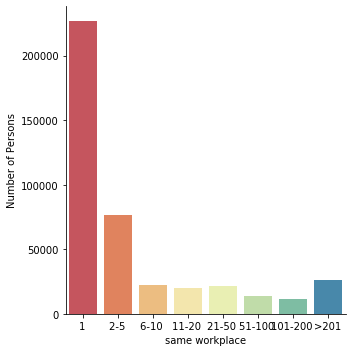

<Figure size 3200x6400 with 0 Axes>

In [15]:
companyCounts=tableUniqueFullNameCounts['count']

#establish the binvals
binVals=np.asarray([0,1,5,10,20,50,100,200,np.max(companyCounts)])

#iterate to sum the number of employees meeting the criterion
binSum=np.zeros([len(binVals)-1,1])
for iBins in range(len(binVals)-1):
    binSum[iBins]=sum(companyCounts[np.logical_and(companyCounts>binVals[iBins],companyCounts<=binVals[iBins+1])])

#import plotting package
import seaborn as sns
#set the name vector    
binNames=['1 ','2-5 ','6-10 ','11-20 ','21-50 ','51-100 ','101-200 ', '>=201']
#set the axes labels
workplaceSizeTable=pd.DataFrame(columns=["same workplace","Number of Persons"])
workplaceSizeTable['Number of Persons']=np.squeeze(binSum)
workplaceSizeTable['Same workplace listing']=np.squeeze(binNames)

#plot the output
sns.catplot(data=workplaceSizeTable, kind="bar", x='same workplace',y='Number of Persons', palette='Spectral');
plt.figure(figsize=(16,32),dpi=200)

Here we have a plot where there are various bin ranges corresponding to the number of other people who have *exactly* the same worplace affiliation listed on the X axis, and the number of people meeting that criteria on the Y axis.  Thus, to be included in the count of persons in the >=201 column/bin, the listing that the user has entered would need to be found listed by at least 201 other people.  This gives us a very rough sense of the overlap in these raw, and unchanged listings.  

Our task here is twofold:

(1) Clean the data such that abberant features (e.g. capitalization, white space, legal entity listing, etc.) don't serve as an impediment to assessing how many people are affiliated with a particular organization

and

(2) To come up with a better measure that can accomidate the "messiness" associated with multiple listings in this field.

Before we do any of this though, lets use a word cloud to get a feel for the relative frequencies of unique company listings in this data.

In [17]:
import wordcloud
#replace interior spaces and periods (which the wordcloud splits at)
spacesReplaced=inputRaw['company'].str.replace(' ','_')
periodsReplaced=spacesReplaced.str.replace('\.','_')

#turn that output into a long string
longString=periodsReplaced.str.cat(sep=' ')

#generate a wordcloud and convert it to svg
outcloud=wordcloud.WordCloud(width=2000, height=1000, max_words=2000).generate(longString)
svgCloud=outcloud.to_svg()
plt.show()